In [1]:
import hls4ml

2023-05-01 15:21:42.607353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 15:21:43.510217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# import load_model
import datetime
import os
from enum import Enum
import cv2
import numpy as np
from PIL import Image
from keras import backend as K
from keras.models import load_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.utils import to_categorical

In [3]:
def load_masks(directory_path, patch_size):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for filepath in tqdm(sorted(os.listdir(directory_path))):
        extension = filepath.split(".")[-1]
        if extension == "jpg" or extension == "png":

            # current image path
            img_path = rf"{directory_path}/{filepath}"
            #print(img_path)

            # convert image to RBG
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            thresh = 127
            max_val = 255
            

            size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
            size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

            image = Image.fromarray(image)

            # Crop original image to size divisible by patch size from top left corner
            image = np.array(image.crop((0, 0, size_x, size_y)))
            image = cv2.resize(image, (854, 854))
            image = cv2.resize(image, (160, 160))

            image = cv2.threshold(image, thresh, max_val, cv2.THRESH_BINARY)[1]
            image = image/255
            #plt.imshow(image)
            #plt.show()
            instances.append(np.squeeze(image))

    return instances

def load_images(directory_path, patch_size):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for filepath in tqdm(sorted(os.listdir(directory_path))):
        extension = filepath.split(".")[-1]
        if extension == "jpg" or extension == "png":

            # current image path
            img_path = rf"{directory_path}/{filepath}"
            #print(img_path)

            # Reads image as BGR
            image = cv2.imread(img_path)

            # convert image to RBG
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
            size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

            image = Image.fromarray(image)

            # Crop original image to size divisible by patch size from top left corner
            image = np.array(image.crop((0, 0, size_x, size_y)))
            image = cv2.resize(image, (854, 854))
            image = cv2.resize(image, (160, 160))
            instances.append(np.squeeze(image))

    return instances

# =====================================================
# prepare training data input images

def get_training_data(root_directory):
    # initialise lists
    image_dataset, mask_dataset = [], []
    ip, mp = [], []

    # define image patch size
    patch_size = 160
    
    # walk through root directory
    for path, directories, files in os.walk(root_directory):
        for subdirectory in directories:
            #print("subdirect",subdirectory)
            # extract training input images and patchify
            if subdirectory == "images":
                image_dataset.extend(
                    load_images(os.path.join(path, subdirectory), patch_size=patch_size))

            # extract training label masks and patchify
            elif subdirectory == "masks":
                mask_dataset.extend(
                    load_masks(os.path.join(path, subdirectory), patch_size=patch_size))
    # return input images and masks
    return np.array(image_dataset), np.array(mask_dataset), 


def create_binary_segmentation_problem(image_dataset, mask_dataset):
    # change problem to binary segmentation problem
    x_reduced, y_reduced = [], []

    # iterate over masks
    for j, mask in tqdm(enumerate(mask_dataset)):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create binary image (zeros)
        binary_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        # iterate over each pixel in mask
        for row in range(_img_height):
            for col in range(_img_width):
                # get image channel across axis=3
                rgb = mask[row, col, :]

                # building hex: #3C1098 = RGB(60, 16, 152) or BGR(152, 16, 60)
                binary_image[row, col] = 1 if rgb[0] == 60 and rgb[1] == 16 and rgb[2] == 152 else 0

        # only keep images with a high percentage of building coverage
        if np.count_nonzero(binary_image == 1) > 0.15 * binary_image.size:
            x_reduced.append(image_dataset[j])
            y_reduced.append(binary_image)

    # return binary image dataset
    return np.array(x_reduced), np.array(y_reduced)


# mask color codes
class MaskColorMap(Enum):
    car = (255, 255, 255)
    no_car = (0, 0, 0)

def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset
    :param num_classes: number of classes
    :return:
    """
    # initialise list for integer encoded masks
    """mapper = {x:[0]*num_classes for x in range(num_classes)}
    for k in mapper:
      temp = mapper[k]
      temp[k] = 1
      mapper[k] = temp"""

    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channel = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)


# datetime for filename saving
dt_now = str(datetime.datetime.now()).replace(".", "_").replace(":", "_")
model_img_save_path = f"{os.getcwd()}/models/final_aerial_segmentation_{dt_now}.png"
model_save_path = f"{os.getcwd()}/models/cv_unet_lite_davis_{dt_now}.hdf5"
model_checkpoint_filepath = os.getcwd() + "/models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
csv_logger = rf"{os.getcwd()}/logs/aerial_segmentation_log_{dt_now}.csv"


# =======================================================
# training metrics

# Mean Intersection-Over-Union: iou = true_positives / (true_positives + false_positives + false_negatives)
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


# jaccard similarity: the size of the intersection divided by the size of the union of two sets
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [4]:
BASE_PATH = ""
data_dir = BASE_PATH+''

In [5]:
# =====================================================
# get training data
# number of classes in segmentation dataset
n_classes = 2
train_size = -1

# create (X, Y) training data
X, Y = get_training_data(root_directory="./")

X = X[:train_size]
Y = Y[:train_size]
Y = np.expand_dims(Y, axis=-1)
    
# extract X_train shape parameters
m, img_height, img_width, img_channels = X.shape

# display images from both training and test sets
display_count = 6
random_index = [np.random.randint(0, m) for _ in range(display_count)]

sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]
#display_images(sample_images, rows=2)

# convert RGB values to integer encoded labels for categorical_crossentropy
Y = one_hot_encode_masks(Y, num_classes=n_classes)
X = X/255 # rescaling

# split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

195it [00:02, 85.13it/s]
195it [00:01, 154.78it/s]
100%|██████████| 194/194 [00:03<00:00, 54.80it/s]


## Model Loading

In [55]:
from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

co = {'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index}
_add_supported_quantized_objects(co)
co["PruneLowMagnitude"] = pruning_wrapper.PruneLowMagnitude

model_dir = os.getcwd()+'/models/'
model_name = 'cv_unet_lite_davis_7k_2023-04-17 11_45_53_940687.hdf5'

model = load_model(
    model_dir + model_name,
    custom_objects=co
)

In [12]:
model_dir = os.getcwd()+'/models/'
model_name = 'cv_unet_lite_davis_450k-12k_distill_2023-05-01 14_52_03_553482.hdf5'

model = load_model(
    model_dir + model_name,
    custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index}
)

In [13]:
#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
sm_layer = list(hls_config["LayerName"].keys())[-1]
hls_config['LayerName'][sm_layer]['Strategy'] = 'stable'
#plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'fpga_model_400to12k_xcu250/'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
#cfg['XilinxPart'] = "xczu9eg-2ffvb1156"

  
hls_model = hls4ml.converters.keras_to_hls(cfg)

Interpreting Model
Topology:
Layer name: input_5, layer type: InputLayer, input shapes: [[None, 160, 160, 3]], output shape: [None, 160, 160, 3]
Layer name: conv2d_31, layer type: Conv2D, input shapes: [[None, 160, 160, 3]], output shape: [None, 160, 160, 4]
Layer name: conv2d_32, layer type: Conv2D, input shapes: [[None, 160, 160, 4]], output shape: [None, 160, 160, 4]
Layer name: max_pooling2d_11, layer type: MaxPooling2D, input shapes: [[None, 160, 160, 4]], output shape: [None, 80, 80, 4]
Layer name: conv2d_33, layer type: Conv2D, input shapes: [[None, 80, 80, 4]], output shape: [None, 80, 80, 8]
Layer name: conv2d_34, layer type: Conv2D, input shapes: [[None, 80, 80, 8]], output shape: [None, 80, 80, 8]
Layer name: max_pooling2d_12, layer type: MaxPooling2D, input shapes: [[None, 80, 80, 8]], output shape: [None, 40, 40, 8]
Layer name: conv2d_35, layer type: Conv2D, input shapes: [[None, 40, 40, 8]], output shape: [None, 40, 40, 12]
Layer name: conv2d_36, layer type: Conv2D, input

In [14]:
hls_model.compile()

Writing HLS project
Done


In [15]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file="UNL_12distill.png")

In [10]:
from hls4ml.model import profiling

Interpreting Model
Topology:
Layer name: input_23, layer type: InputLayer, input shapes: [[None, 160, 160, 3]], output shape: [None, 160, 160, 3]
Layer name: conv2d_317, layer type: Conv2D, input shapes: [[None, 160, 160, 3]], output shape: [None, 160, 160, 4]
Layer name: conv2d_318, layer type: Conv2D, input shapes: [[None, 160, 160, 4]], output shape: [None, 160, 160, 4]
Layer name: max_pooling2d_57, layer type: MaxPooling2D, input shapes: [[None, 160, 160, 4]], output shape: [None, 80, 80, 4]
Layer name: conv2d_319, layer type: Conv2D, input shapes: [[None, 80, 80, 4]], output shape: [None, 80, 80, 8]
Layer name: conv2d_320, layer type: Conv2D, input shapes: [[None, 80, 80, 8]], output shape: [None, 80, 80, 8]
Layer name: max_pooling2d_58, layer type: MaxPooling2D, input shapes: [[None, 80, 80, 8]], output shape: [None, 40, 40, 8]
Layer name: conv2d_321, layer type: Conv2D, input shapes: [[None, 40, 40, 8]], output shape: [None, 40, 40, 16]
Layer name: conv2d_322, layer type: Conv2D

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

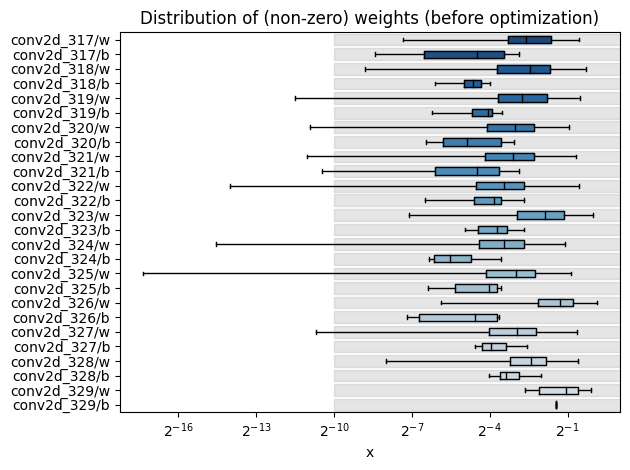

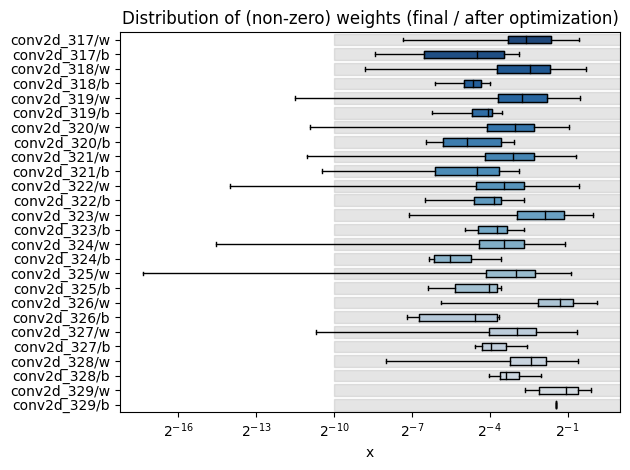

In [11]:
profiling.numerical(model=model, hls_model=hls_model)

In [43]:
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras import quantized_bits
from qkeras import QDense, QActivation
import pprint

In [56]:
# Energy Profiling dmodel: Student w/o Quantization
q = run_qtools.QTools(model, 
                      process="horowitz", 
                      source_quantizers=[quantized_bits(16, 5, 1)], 
                      is_inference=True, 
                      weights_path=None,
                      keras_quantizer="fp16",
                      keras_accumulator="fp16", 
                      for_reference=False)
q.qtools_stats_print()

energy_dict = q.pe(
    weights_on_memory="fixed",
    activations_on_memory="fixed",
    min_sram_size=8*16*1024*1024,
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

{
    "source_quantizers": [
        {
            "quantizer_type": "quantized_bits",
            "bits": 16,
            "int_bits": 6,
            "is_signed": true
        }
    ],
    "conv2d_317": {
        "layer_type": "Conv2D",
        "input_quantizer_list": [
            {
                "quantizer_type": "quantized_bits",
                "bits": 16,
                "int_bits": 6,
                "is_signed": true
            }
        ],
        "weight_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": [
                3,
                3,
                3,
                4
            ]
        },
        "bias_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": 4
        },
        "multiplier": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "op_type": "mul"
        },
        "accumulator": {
            "quantizer_ty